In [15]:
# Importing Libraries
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.12.0


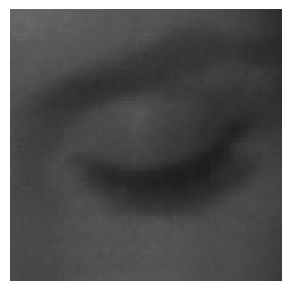

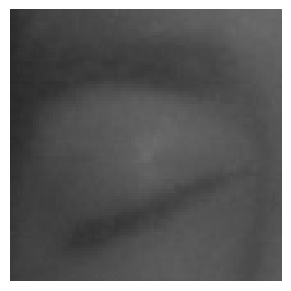

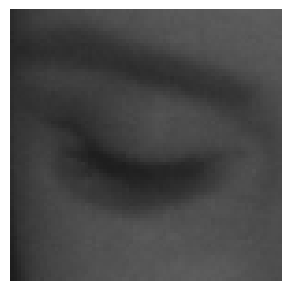

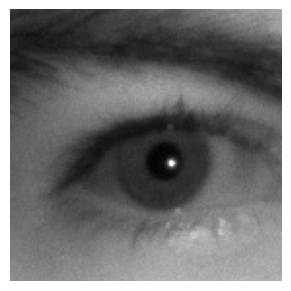

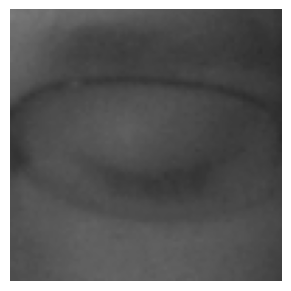

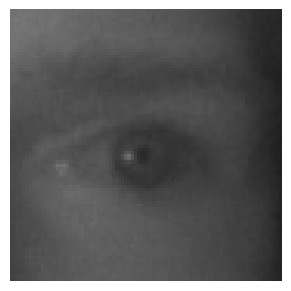

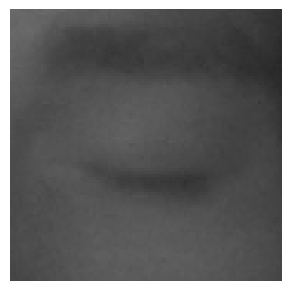

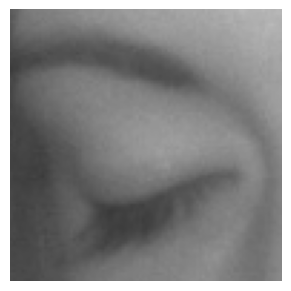

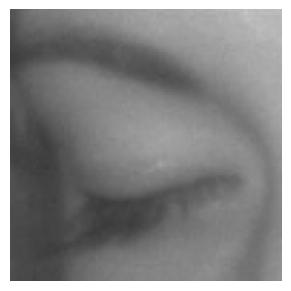

In [16]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

In [17]:
# Preparing Data for Training
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

Found 3400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [18]:
# Defining Model
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [19]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [20]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))

    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten,256)

    output  = Dense(2, activation="softmax")(dense_1)
    model  =  Model(inputs=[inputs],outputs = [output])
    
    model.compile(loss=['categorical_crossentropy'] , optimizer = 'adam' , metrics =["accuracy"])

    return model

In [35]:
model = model_fer((48,48,1))
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 32)        0   

In [36]:
# Initializing Model

epochs = 7
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
callbacks = [checkpoint]

In [37]:
# Training Model

history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/7
53/53 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.9445
Epoch 1: saving model to model_weights.h5
53/53 [==============================] - 9s 152ms/step - loss: 0.1508 - accuracy: 0.9445 - val_loss: 0.4108 - val_accuracy: 0.8819
Epoch 2/7
53/53 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9910
Epoch 2: saving model to model_weights.h5
53/53 [==============================] - 8s 159ms/step - loss: 0.0263 - accuracy: 0.9910 - val_loss: 0.0484 - val_accuracy: 0.9757
Epoch 3/7
53/53 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9973
Epoch 3: saving model to model_weights.h5
53/53 [==============================] - 8s 154ms/step - loss: 0.0123 - accuracy: 0.9973 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 4/7
53/53 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9985
Epoch 4: saving model to model_weights.h5
53/53 [==============================] - 8s 153ms/step - loss: 0.00

In [38]:
# Model Evaluation

model.evaluate(validation_generator)

10/10 [==============================] - 0s 34ms/step - loss: 0.0016 - accuracy: 1.0000


[0.001584511250257492, 1.0]

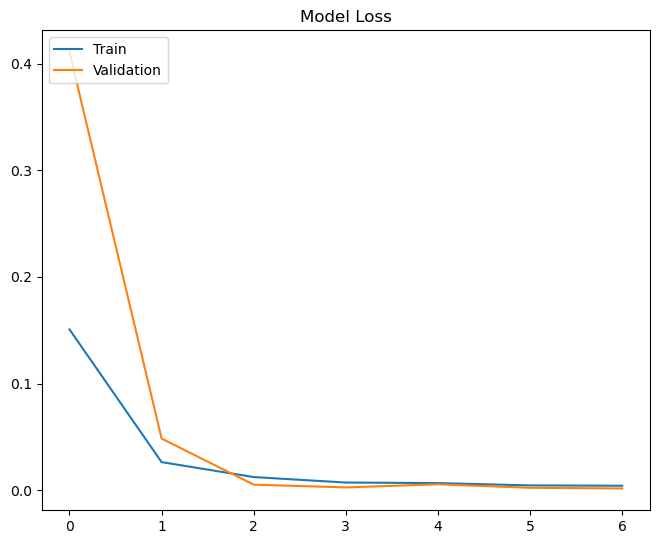

In [39]:
# Plotting Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

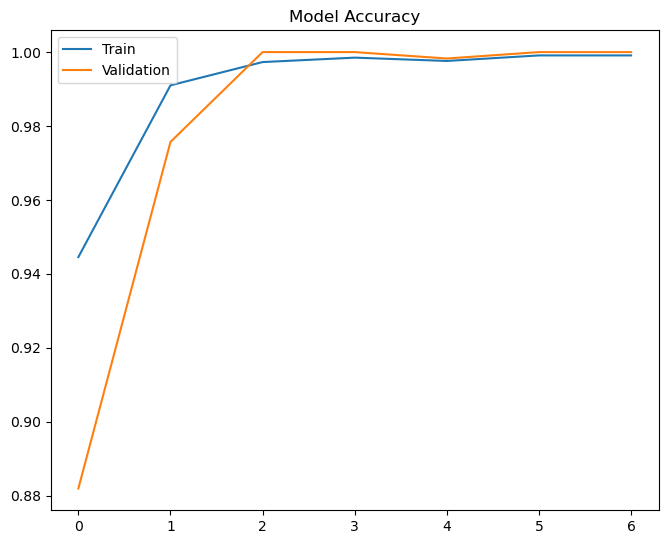

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

In [41]:
# Saving Model

model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)